In [1]:
# setting up all of the packages
!pip install -q optuna

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
# import torch
# import torch.nn as nn
import optuna
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
# from utils import * 
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# raster and dataframe handling packages
import rasterio
import rioxarray as rio

# stats packages
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

# print(os.getcwd())
# custom functions from class LEAP env.
# from utils import * 

# plotting parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

# Preparing our predictor and predictand data
predictor: (X, TerraClim climate variables), predictant: (Y, MODIS LAI) data

In [2]:
# import os
# import glob
# import pandas as pd

# # Paths
# data_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/"

# # Files
# train_files = sorted(glob.glob(os.path.join(data_path, "x_train_lags_*.csv")))
# test_files  = sorted(glob.glob(os.path.join(data_path, "x_test_lags_*.csv")))

# y_train_file = os.path.join(data_path, "y_train_lai.csv")
# y_test_file  = os.path.join(data_path, "y_test_lai.csv")

# def load_lags_for_variable(file_list, variable):
#     """
#     Load all lag features for a given variable from a list of CSVs and merge them.
#     """
#     dfs = []
#     for f in file_list:
#         df = pd.read_csv(f, parse_dates=["time"])
#         # Filter only the variable and its lags if present
#         cols = [c for c in df.columns if c.startswith(variable)]
#         cols += ["time", "lat", "lon"]
#         df = df[cols]
#         # Set multi-index for alignment
#         df = df.set_index(["time", "lat", "lon"])
#         dfs.append(df)
    
#     # Merge all lag files (inner join to ensure alignment)
#     merged = pd.concat(dfs, axis=1, join="inner")
    
#     return merged

# def load_variable_dataset(variable):
#     """
#     Loads train/test datasets for a single variable and aligns with y (LAI)
#     """
#     # Load X
#     X_train = load_lags_for_variable(train_files, variable)
#     X_test  = load_lags_for_variable(test_files, variable)
    
#     # Load Y
#     y_train = pd.read_csv(y_train_file, parse_dates=["time"]).set_index(["time", "lat", "lon"])
#     y_test  = pd.read_csv(y_test_file, parse_dates=["time"]).set_index(["time", "lat", "lon"])
    
#     # Align with X (inner join)
#     y_train = y_train.loc[X_train.index]
#     y_test  = y_test.loc[X_test.index]
    
#     # Combine into one DataFrame with a column to indicate train/test
#     train_df = X_train.copy()
#     train_df["LAI"] = y_train["lai"]
#     train_df["set"] = "train"
    
#     test_df = X_test.copy()
#     test_df["LAI"] = y_test["lai"]
#     test_df["set"] = "test"
    
#     combined_df = pd.concat([train_df, test_df])
    
#     # Reset index to have lat/lon/time as columns
#     combined_df = combined_df.reset_index()
    
#     return combined_df

# # tmmx
# # tmmn
# variable = "tmmx"
# df = load_variable_dataset(variable)
# print(df.shape)
# print(df.head())



In [3]:
# import matplotlib.pyplot as plt
# from scipy.stats import linregress
# import numpy as np

# # Extract lag columns
# lag_cols = [c for c in df.columns if c.startswith(variable)]  # exclude raw variable if desired

# # Grid layout
# n_lags = len(lag_cols)
# n_cols = 4
# n_rows = (n_lags + n_cols - 1) // n_cols

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
# axes = axes.flatten()

# for i, col in enumerate(lag_cols):
#     ax = axes[i]
    
#     x = df[col].values
#     y = df["LAI"].values
    
#     # Scatter plot with custom color
#     ax.scatter(x, y, alpha=0.5, s=10, color="#addc30")
    
#     # Linear regression
#     slope, intercept, r_value, p_value, std_err = linregress(x, y)
#     y_pred = slope * x + intercept
#     ax.plot(x, y_pred, color="#3e4989", lw=2)
    
#     # R²
#     ax.text(0.05, 0.95, f"R² = {r_value**2:.2f}", transform=ax.transAxes,
#             fontsize=10, verticalalignment='top')
    
#     ax.set_xlabel(col)
#     ax.set_ylabel("LAI")
#     ax.set_title(f"{col} vs LAI")

# # Remove empty axes
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


In [4]:
train_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/"
test_path  = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/"

train_files = sorted(glob.glob(os.path.join(train_path, "x_train_lags_*.csv")))
test_files  = sorted(glob.glob(os.path.join(test_path,  "x_test_lags_*.csv")))

print(train_files)

def load_and_merge_lags(file_list):
    dfs = []

    for f in file_list:
        df = pd.read_csv(f, parse_dates=["time"])
        
        # Set index for safe merging
        df = df.set_index(["time", "lat", "lon"])
        
        dfs.append(df)

    # Inner join ensures perfect alignment
    merged = pd.concat(dfs, axis=1, join="inner")

    return merged

# model 1
# predictors = ["tmmx", "tmmx_lag16", "tmmx_lag14", 
#               "tmmn_lag15", "tmmn_lag5", "tmmn_lag6",
#               "pr", "pr_lag3", "pr_lag12",
#               "pdsi", "pdsi_lag18", "pdsi_lag14",
#               "def_lag7", "def_lag8", "def_lag6",
#               "vpd_lag16", "vpd_lag17", "vpd_lag6",
#               "soil_lag5", "soil_lag6", "soil_lag18",
#              ]

# model 2
predictors = ["tmmx", "tmmx_lag3", "tmmx_lag6",
              "tmmx_lag1","tmmx_lag2","tmmx_lag5","tmmx_lag7","tmmx_lag13","tmmx_lag14",
              "tmmn_lag2", "tmmn_lag3", "tmmn_lag5", "tmmn_lag6", "tmmn_lag17",
              "tmmn_lag4", "tmmn_lag9", "tmmn_lag10", "tmmn_lag13", "tmmn_lag18",
              "pr",
              "pr_lag3","pr_lag14",
              "pdsi","pdsi_lag5",
              "def_lag3","def_lag6","def_lag7",
              "soil_lag3","soil_lag6", "soil_lag7","soil_lag9",
             ]

X_train = load_and_merge_lags(train_files)[predictors]
X_test  = load_and_merge_lags(test_files)[predictors]

print(X_train.shape)
print(X_test.shape)

print(X_train.index.names)
print(X_train.columns)

print(X_train.head())

test_index = X_test.index
print(test_index)

['/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_def.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_pdsi.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_pr.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_soil.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_tmmn.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_tmmx.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_vpd.csv']
(331506, 31)
(15786, 31)
['time', 'lat', 'lon']
Index(['tmmx', 'tmmx_lag3', 'tmmx_lag6', 'tmmx_lag1', 'tmmx_lag2', 'tmmx_lag5',
       'tmmx_lag7', 'tmmx_lag13', 'tmmx_lag14', 'tmmn_lag2', 'tmmn_lag3',
       'tmmn_lag5', 'tmmn_lag6', 'tmmn_lag17', 'tmmn_lag4', 'tmmn_lag9',
       'tmmn_lag10', 'tmmn_lag13', 'tmmn_lag18', 'pr', 'pr_lag3', 'pr_lag14',
       'pdsi', 'pdsi_lag5', 'def_lag3', 'def_lag6', 'def_lag7', 'soil_lag3',

In [5]:
y_train_file = os.path.join(train_path, "y_train_lai.csv")
y_test_file  = os.path.join(test_path,  "y_test_lai.csv")

# Load y data
y_train = pd.read_csv(y_train_file, parse_dates=["time"]).set_index(["time", "lat", "lon"])
y_test  = pd.read_csv(y_test_file,  parse_dates=["time"]).set_index(["time", "lat", "lon"])

# Align with merged X (inner join ensures exact matching rows)
y_train = y_train.loc[X_train.index]
y_test  = y_test.loc[X_test.index]

print(y_train.shape)
print(y_test.shape)

print(y_train.head())

(331506, 1)
(15786, 1)
                                    lai
time       lat        lon              
2008-07-31 -13.325002 -69.725  0.093054
2008-08-31 -13.325002 -69.725 -0.001428
2008-09-30 -13.325002 -69.725 -0.106578
2008-10-31 -13.325002 -69.725 -0.042835
2008-11-30 -13.325002 -69.725 -0.163796


In [6]:
# # Pick a date to map
# date_to_plot = "2008-07-31"

# # Select rows for that time
# df_map = y_train.loc[date_to_plot]

# # Reset index to get lat/lon as columns
# df_map = df_map.reset_index()

# gdf = gpd.GeoDataFrame(
#     df_map,
#     geometry=gpd.points_from_xy(df_map['lon'], df_map['lat']),
# )


# fig, ax = plt.subplots(figsize=(8,6))
# gdf.plot(column="lai", ax=ax, legend=True, cmap="viridis", markersize=50)
# ax.set_title(f"LAI values on {date_to_plot}")
# plt.show()

## Split our data into training, validation and testing and normalize
Look at the entire time sequence of our data: 19 years, 12 months per year
(19yrs x 12months) = 228 time steps

We want the last two years to be our testing dataset: 2019 and 2020
Therefore, the first 17 tears are our training and validation data
Of this, 80% must be training (14 years), 20% must be validation (3 years)

So the final break-down is:
Training: 2002-2015 (14yrs x 12months = 168 ts)
Validation: 2016-2018 (3yrs x 12months = 36 ts)
Testing: 2019-2020 (2yrs x 12months = 24 ts)

In [8]:
train_yr_start = 2007
test_yr_start = 2019
test_yr_end = 2020

print('something')

something


In [10]:
# Best params: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}

# Best params: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}


n_estimators      = 300 #100    # Number of trees in random forest
min_samples_split = 5 #10     # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = 'log2' #'sqrt' #None   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = None #30 #None     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree



# reg0 = RandomForestRegressor(n_estimators=n_estimators,
#                              min_samples_split=min_samples_split,
#                              min_samples_leaf=min_samples_leaf,
#                              max_features=max_features,
#                              max_depth=max_depth,
#                              bootstrap=bootstrap)

# rf_tas = reg0.fit(X_train,y_train['lai'])

In [11]:
import os
import joblib

# export and SAVE model
model_path = f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/RF/"
os.makedirs(model_path, exist_ok=True)

joblib.dump(
    rf_tas,
    os.path.join(
        model_path,
        f"rf_yr"
        f"{train_yr_start % 100}"
        f"{test_yr_start % 100}{test_yr_end % 100}_v2.joblib"
    )
)

['/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/RF/rf_yr71920_v2.joblib']

In [12]:
print('done')

done


In [13]:
import joblib

model_path = f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/RF/"

model_file = os.path.join(
    model_path,
    f"rf_yr"
        f"{train_yr_start % 100}"
        f"{test_yr_start % 100}{test_yr_end % 100}_v2.joblib"
)

reg0 = joblib.load(model_file)

pr            0.050452
def_lag6      0.046500
pr_lag14      0.044567
pr_lag3       0.044445
def_lag7      0.041111
tmmx          0.039698
soil_lag6     0.038163
pdsi          0.037428
tmmn_lag3     0.035522
soil_lag7     0.034824
tmmn_lag6     0.033367
tmmx_lag3     0.032247
def_lag3      0.031598
tmmn_lag18    0.031396
pdsi_lag5     0.031393
tmmn_lag5     0.029909
tmmx_lag5     0.029892
soil_lag3     0.029760
tmmx_lag6     0.028491
tmmn_lag17    0.027878
tmmn_lag4     0.027546
tmmx_lag14    0.026741
tmmx_lag13    0.026488
tmmn_lag2     0.026346
tmmn_lag10    0.026284
tmmn_lag13    0.026049
tmmn_lag9     0.025546
tmmx_lag2     0.025430
tmmx_lag7     0.024565
soil_lag9     0.024485
tmmx_lag1     0.021879
dtype: float64


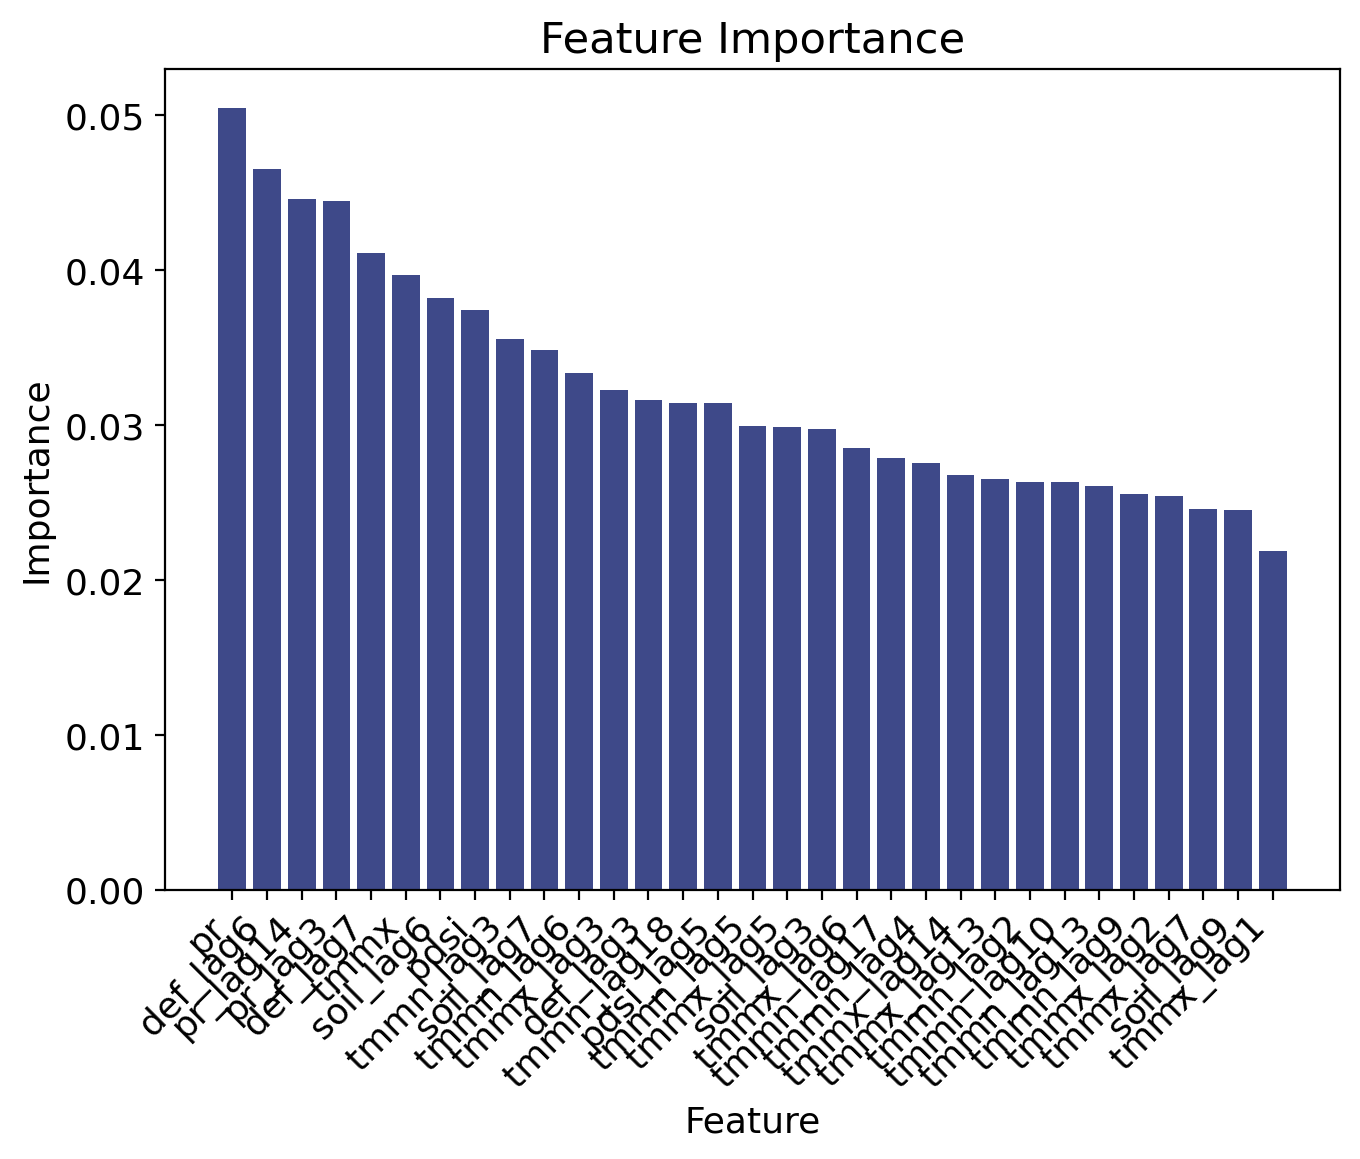

In [14]:
# reg0.feature_importances_

importances = pd.Series(
    reg0.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(importances)

plt.figure(figsize=(7, 6))

plt.bar(
    range(len(importances)),
    importances.values,
    color="#3e4989"
)

plt.xticks(
    ticks=range(len(importances)),
    labels=importances.index,
    rotation=45,
    ha="right"
)

plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")

plt.tight_layout()
plt.show()


In [16]:
# y_test_pre = rf_tas.predict(X_test)
# y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

# y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
#                                'latitude': X_test_xr.latitude.values, 
#                                'longitude': X_test_xr.longitude.values},
#                         data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

In [17]:
y_pred_test = reg0.predict(X_test)
y_pred_test

array([0.12669133, 0.09337475, 0.10875037, ..., 0.10612609, 0.08303444,
       0.1154255 ], shape=(15786,))

RMSE: 0.2829581725027785
MAE: 0.1937537206872231
R²: -0.0495328877513348


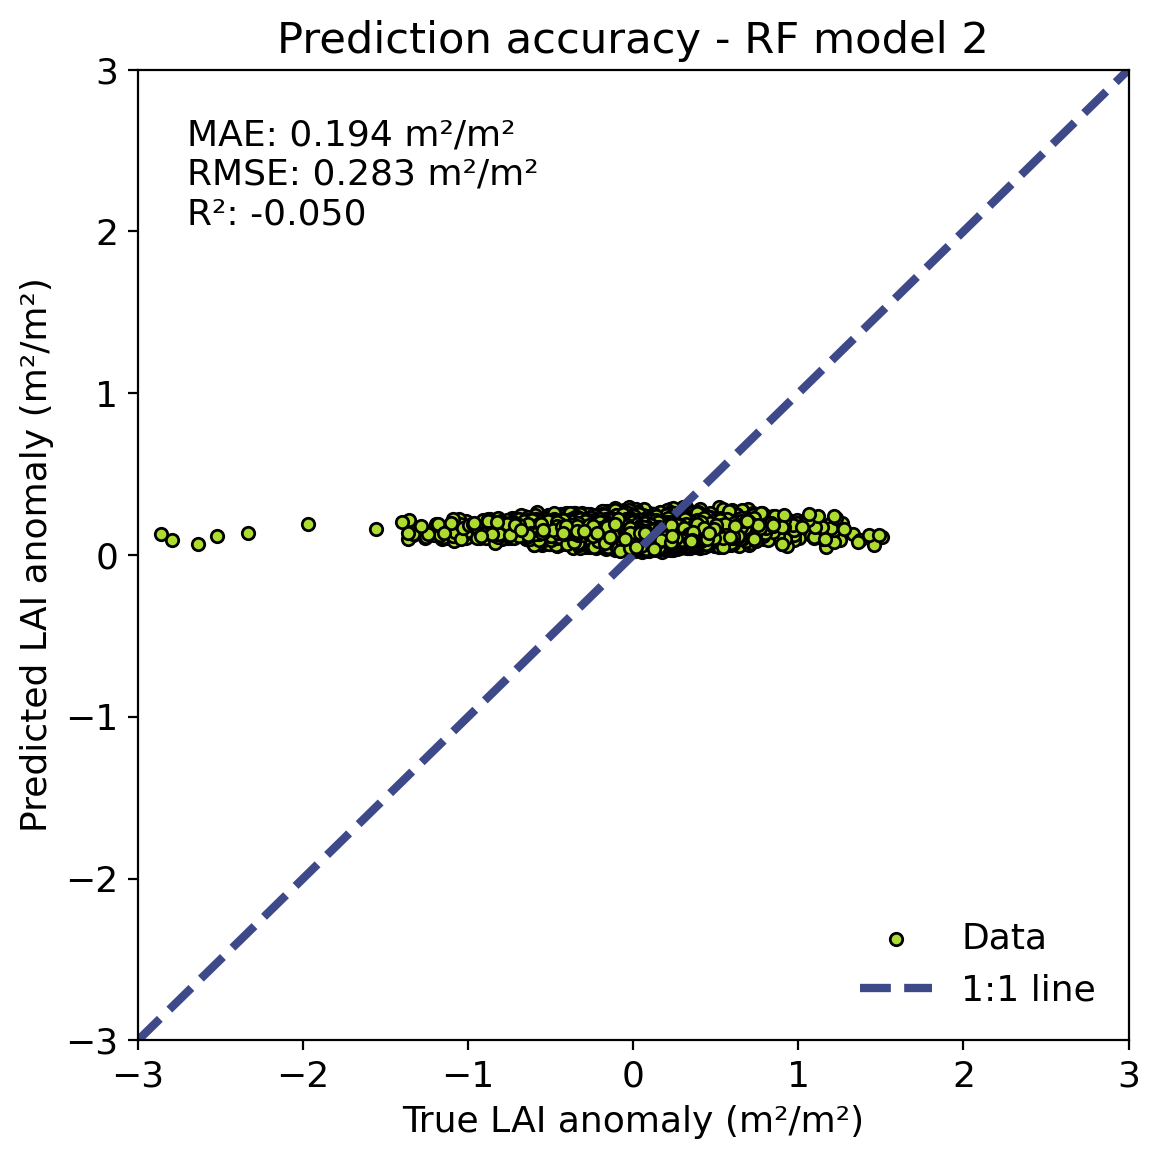

np.float64(-0.0495328877513348)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure y_test and y_pred_test are 1D arrays
y_true = y_test.values.ravel()       # if DataFrame
y_pred = y_pred_test.ravel()         # if ndarray or DataFrame

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

# # Scatter plot: True vs Predicted
# plt.figure(figsize=(6,6))
# plt.scatter(y_true, y_pred, alpha=0.5, color="tab:blue", edgecolor="k")

# # 1:1 reference line
# min_val = min(y_true.min(), y_pred.min())
# max_val = max(y_true.max(), y_pred.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 line")

# plt.xlabel("True")
# plt.ylabel("Predicted")
# plt.title("True vs Predicted")

# # Annotate metrics
# plt.text(0.05, 0.95,
#          f"RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}",
#          transform=plt.gca().transAxes,
#          verticalalignment='top',
#          bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# plt.legend()
# plt.tight_layout()
# plt.show()

def plot_true_vs_pred(
    y_true,
    y_pred,
    overall_rmse=None,
    overall_mae=None,
    point_color="tab:blue",
    edge_color="k",
    line_color="r",
    alpha=1,
    xlim=None,
    ylim=None,
    figsize=(6, 6),
    point_size=15,
    line_width=2.5
):
    # ---- R² ----
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    overall_r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

    # ---- Plot ----
    plt.figure(figsize=figsize)
    plt.scatter(
        y_true,
        y_pred,
        s=point_size,
        alpha=alpha,
        edgecolor=edge_color,
        color=point_color,
        label="Data"
    )

    # ---- 1:1 line ----
    if xlim is None:
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
    else:
        min_val, max_val = xlim

    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle="--",
        linewidth=line_width,
        color=line_color,
        label="1:1 line"
    )

    # ---- Axis limits ----
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # ---- Labels ----
    plt.xlabel("True LAI anomaly (m²/m²)")
    plt.ylabel("Predicted LAI anomaly (m²/m²)")
    plt.title(f"Prediction accuracy - RF model 2")

    # ---- Metrics text (NO BOX) ----
    metrics = f"R²: {r2:.3f}"
    if overall_rmse is not None:
        metrics = f"RMSE: {rmse:.3f} m²/m²\n" + metrics
    if overall_mae is not None:
       metrics = f"MAE: {mae:.3f} m²/m²\n" + metrics

    plt.text(
        0.05, 0.95,
        metrics,
        transform=plt.gca().transAxes,
        va="top"
    )

    plt.legend()
    plt.tight_layout()
    plt.show()

    return overall_r2

plot_true_vs_pred(
    y_true,
    y_pred,
    overall_rmse=rmse,
    overall_mae=mae,
    point_color="#addc30",
    line_color="#3e4989",
    xlim=(-3, 3),
    ylim=(-3, 3),
    alpha=1,
    point_size=20,
    line_width=3
)


In [22]:
def metric_to_raster(df, metric):
    lats = np.sort(df["lat"].unique())
    lons = np.sort(df["lon"].unique())

    raster = np.full((len(lats), len(lons)), np.nan, dtype=float)

    for _, row in df.iterrows():
        lat_idx = np.where(lats == row["lat"])[0][0]
        lon_idx = np.where(lons == row["lon"])[0][0]
        raster[lat_idx, lon_idx] = row[metric]

    return raster, lats, lons

    

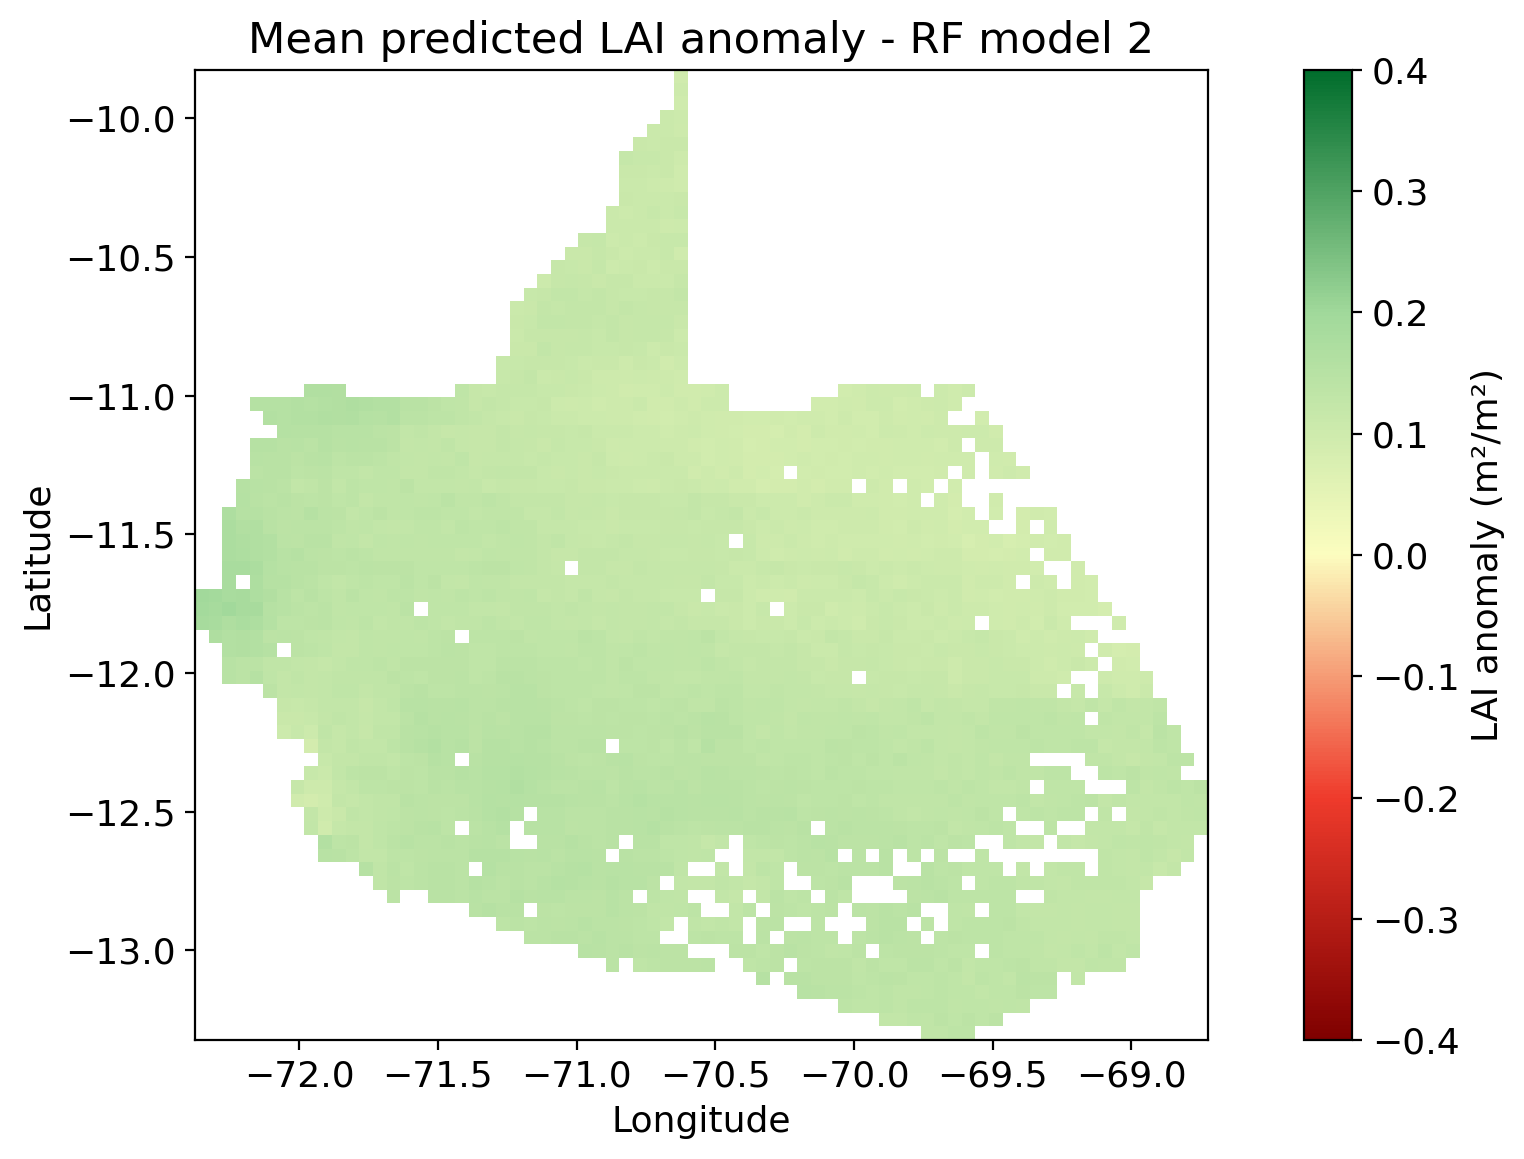

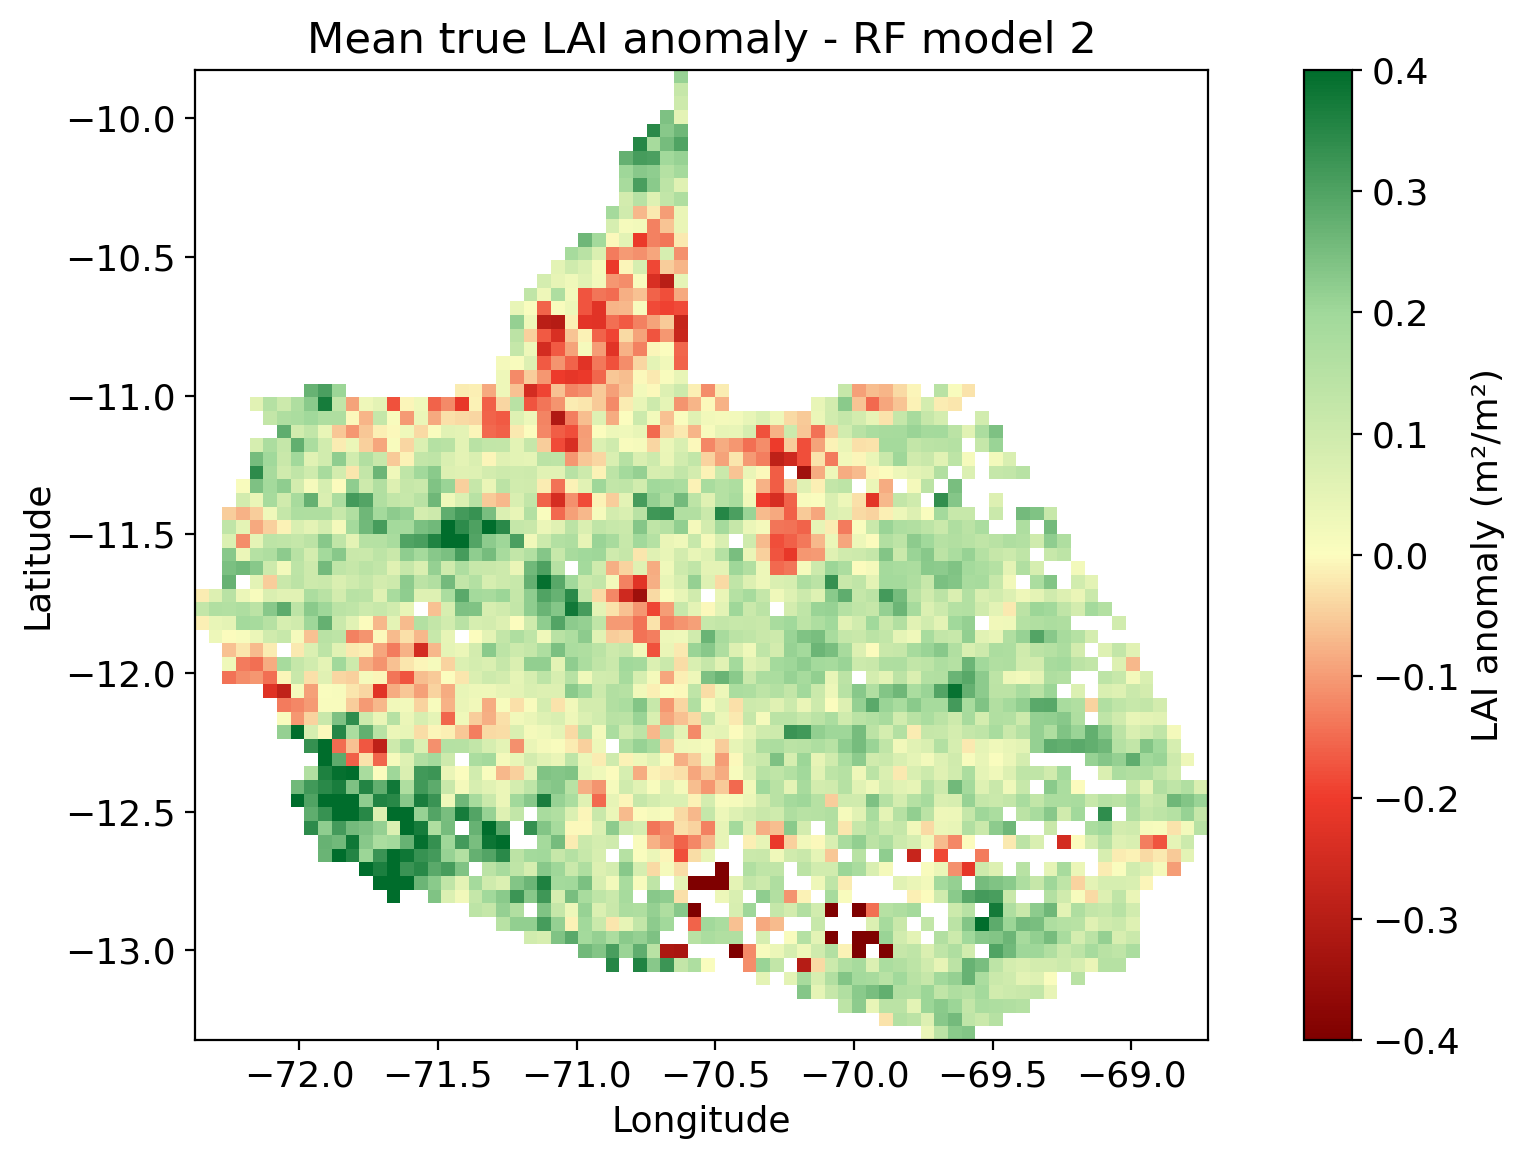

In [23]:
predsTargs = pd.DataFrame({
        # "time": test_index.get_level_values("time"),
        "lat":  test_index.get_level_values("lat"),
        "lon":  test_index.get_level_values("lon"),
        "pred": y_pred_test.ravel(),  # flatten to 1D
        "true": y_test.values.ravel() # flatten to 1D
    })

# print(len(test_index.get_level_values("time")))
# print(len(y_pred_test.ravel()))
# print(len(y_test.values.ravel()))
# print(len(test_index.get_level_values("lat")))

predsTargs_mean = (
    predsTargs
    .groupby(["lat", "lon"], as_index=False)
    .mean(numeric_only=True)
)

# print(predsTargs_mean.head())

preds_raster, lats, lons = metric_to_raster(predsTargs_mean, "pred")
preds_raster = np.flipud(preds_raster)
targs_raster, lats, lons = metric_to_raster(predsTargs_mean, "true")
targs_raster = np.flipud(targs_raster)

# print(preds_raster)

# print(predsTargs)

import matplotlib.pyplot as plt
import matplotlib.colors as colors

# ---- MANUAL COLOR SCALE ----
vmin = -0.4   # <-- change freely
vmax =  0.4   # <-- change freely

# ---- Custom diverging colormap ----
custom_colors = [
    "#7f0000",  # dark red
    "#ef3b2c",  # light red
    "#fcfdbf",  # tan
    "#a1d99b",  # light green
    "#006d2c"   # dark green
]

cmap = colors.LinearSegmentedColormap.from_list(
    "red_tan_green",
    custom_colors,
    N=256
)

norm = colors.Normalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(10, 6))
plt.imshow(
    preds_raster,
    cmap=cmap,
    norm=norm,
    origin="upper",
    extent=[min(lons), max(lons), min(lats), max(lats)]
)
plt.colorbar(label="LAI anomaly (m²/m²)")
plt.title(f"Mean predicted LAI anomaly - RF model 2")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(
    targs_raster,
    cmap=cmap,
    norm=norm,
    origin="upper",
    extent=[min(lons), max(lons), min(lats), max(lats)]
)
plt.colorbar(label="LAI anomaly (m²/m²)")
plt.title(f"Mean true LAI anomaly - RF model 2")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [24]:
def compute_error_per_pixel(test_index, y_pred_test, y_test):
    df = pd.DataFrame({
        "lat":  test_index.get_level_values("lat"),
        "lon":  test_index.get_level_values("lon"),
        "pred": y_pred_test.ravel(),  # flatten to 1D
        "true": y_test.values.ravel() # flatten to 1D
    })

    def rmse(x, y):
        return np.sqrt(np.mean((x - y)**2))

    def mae(x, y):
        return np.mean(np.abs(x - y))

    error_df = df.groupby(["lat", "lon"]).apply(
        lambda g: pd.Series({
            "rmse": rmse(g["pred"], g["true"]),
            "mae": mae(g["pred"], g["true"])
        })
    ).reset_index()

    return error_df

In [25]:
error_df = compute_error_per_pixel(test_index, y_pred_test, y_test)
print(error_df.head())

         lat        lon      rmse       mae
0 -13.325002 -69.725000  0.194578  0.129561
1 -13.325002 -69.674995  0.130947  0.115371
2 -13.325002 -69.625000  0.189481  0.154359
3 -13.325002 -69.575000  0.192567  0.158934
4 -13.275002 -69.875000  0.333896  0.248564


/tmp/ipykernel_107/517935267.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_df = df.groupby(["lat", "lon"]).apply(


In [26]:
rmse_raster, lats, lons = metric_to_raster(error_df, "rmse")
rmse_raster = np.flipud(rmse_raster)

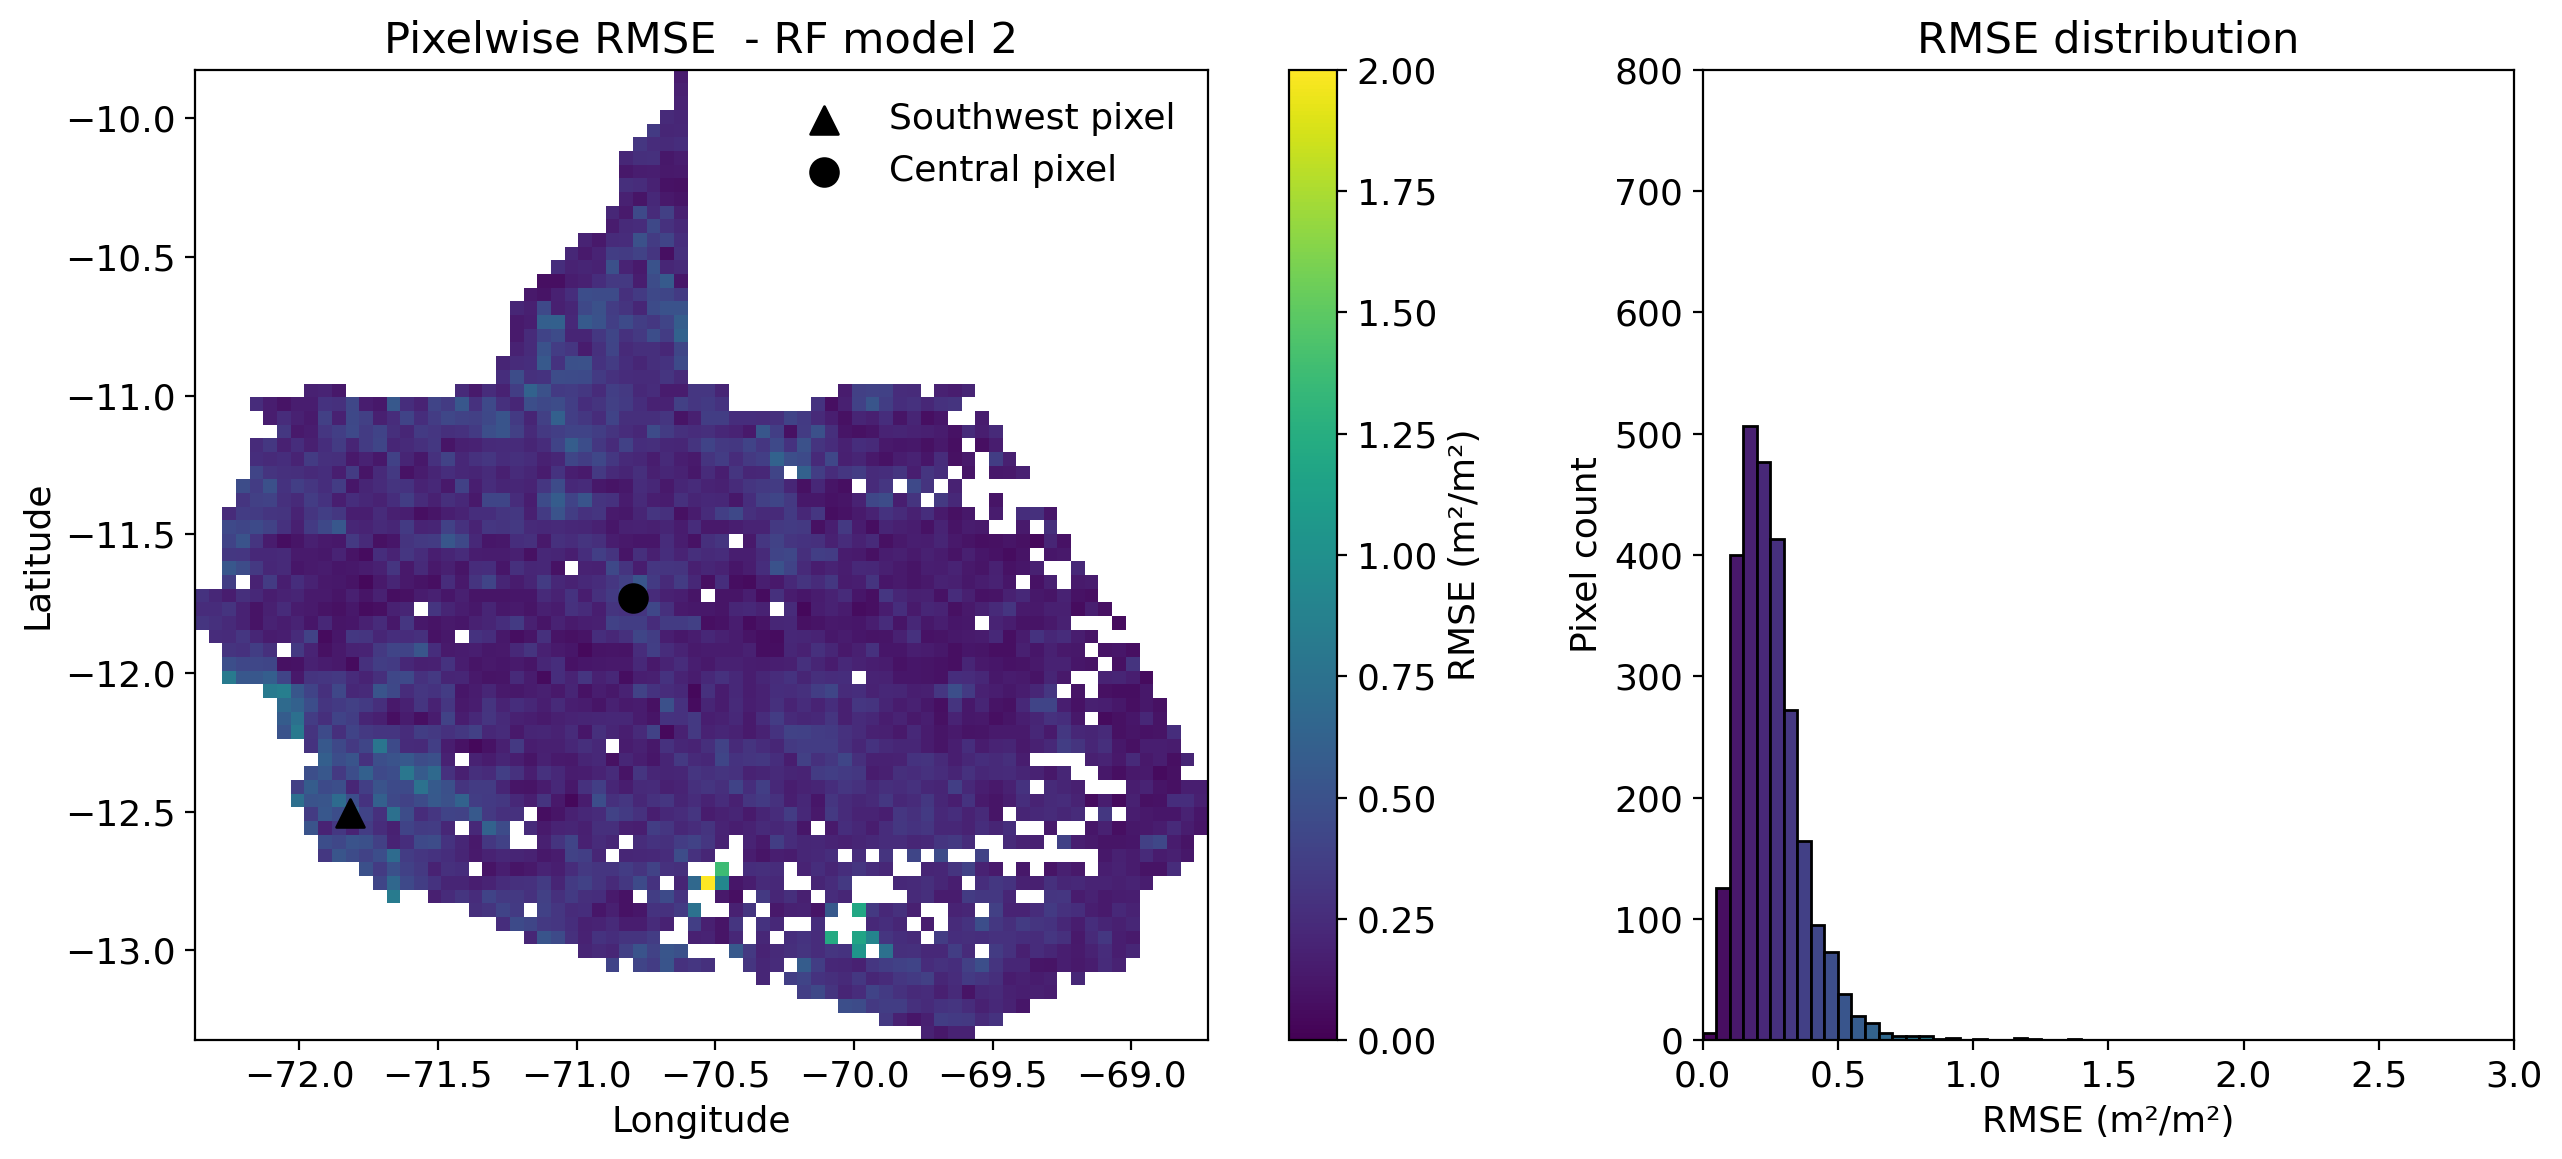

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# ======================================================
# User-defined reference points
# ======================================================
sw_lat, sw_lon = -12.504240199016463, -71.818702040585   # southwest
ct_lat, ct_lon = -11.730855612666398, -70.79697352496   # central

# ======================================================
# Helper: extract raster value at lat/lon (nearest valid)
# ======================================================
def extract_nearest_valid(raster, lats, lons, lat, lon, max_search=5):
    lat_idx = np.argmin(np.abs(lats - lat))
    lon_idx = np.argmin(np.abs(lons - lon))

    for w in range(max_search):
        lat_slice = slice(max(lat_idx-w,0), min(lat_idx+w+1,raster.shape[0]))
        lon_slice = slice(max(lon_idx-w,0), min(lon_idx+w+1,raster.shape[1]))
        sub_raster = raster[lat_slice, lon_slice]
        if np.any(np.isfinite(sub_raster)):
            return np.nanmean(sub_raster)
    return np.nan  # no valid neighbors

# ======================================================
# Extract RMSE values at reference points
# ======================================================
rmse_sw = extract_nearest_valid(rmse_raster, lats, lons, sw_lat, sw_lon)
rmse_ct = extract_nearest_valid(rmse_raster, lats, lons, ct_lat, ct_lon)

# print(f"SW RMSE: {rmse_sw:.3f} m²/m²")
# print(f"CT RMSE: {rmse_ct:.3f} m²/m²")

# ---- Shared color scale ----
vmin = 0.0
vmax = 2.0
cmap = plt.cm.viridis
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# ---- Histogram axis controls ----
hist_xlim = (0, 3)
hist_ylim = (0, 800)

# ---- Figure ----
fig, (ax_map, ax_hist) = plt.subplots(
    1, 2, figsize=(14, 6),
    gridspec_kw={"width_ratios": [2, 1]}
)

# ---- RMSE map ----
im = ax_map.imshow(
    rmse_raster,
    cmap=cmap,
    norm=norm,
    origin="upper",
    extent=[min(lons), max(lons), min(lats), max(lats)]
)

cbar = fig.colorbar(im, ax=ax_map)
cbar.set_label("RMSE (m²/m²)")

ax_map.set_title(f"Pixelwise RMSE  - RF model 2")
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# ---- Add points with different markers ----
ax_map.scatter(sw_lon, sw_lat, s=100, c='black', marker='^', edgecolor='black', zorder=5, label="Southwest pixel")
ax_map.scatter(ct_lon, ct_lat, s=100, c='black', marker='o', edgecolor='black', zorder=5, label="Central pixel")

ax_map.legend(loc="upper right", frameon=False)

# ---- Histogram ----
rmse_flat = rmse_raster[np.isfinite(rmse_raster)]

n, bins, patches = ax_hist.hist(
    rmse_flat,
    bins=40,
    range=(vmin, vmax),
    edgecolor="black"
)

# Color bins with same colormap
for patch, left, right in zip(patches, bins[:-1], bins[1:]):
    bin_center = 0.5 * (left + right)
    patch.set_facecolor(cmap(norm(bin_center)))

# ---- Histogram axes ----
if hist_xlim is not None:
    ax_hist.set_xlim(hist_xlim)
if hist_ylim is not None:
    ax_hist.set_ylim(hist_ylim)

ax_hist.set_xlabel("RMSE (m²/m²)")
ax_hist.set_ylabel("Pixel count")
ax_hist.set_title("RMSE distribution")

plt.tight_layout()
plt.show()

# ---- Debug prints ----
# print("Raster lat range:", lats.min(), "to", lats.max())
# print("Raster lon range:", lons.min(), "to", lons.max())
# print("SW point:", sw_lat, sw_lon)
# print("CT point:", ct_lat, ct_lon)

lat_idx = np.argmin(np.abs(lats - sw_lat))
lon_idx = np.argmin(np.abs(lons - sw_lon))

# print("SW pixel indices:", lat_idx, lon_idx)
# print("SW raster value:", rmse_raster[lat_idx, lon_idx])


In [29]:
df = pd.DataFrame({
    "time": test_index.get_level_values("time"),
    "lat":  test_index.get_level_values("lat"),
        "lon":  test_index.get_level_values("lon"),
        "pred": y_pred_test.ravel(),  # flatten to 1D
        "true": y_test.values.ravel() # flatten to 1D
})

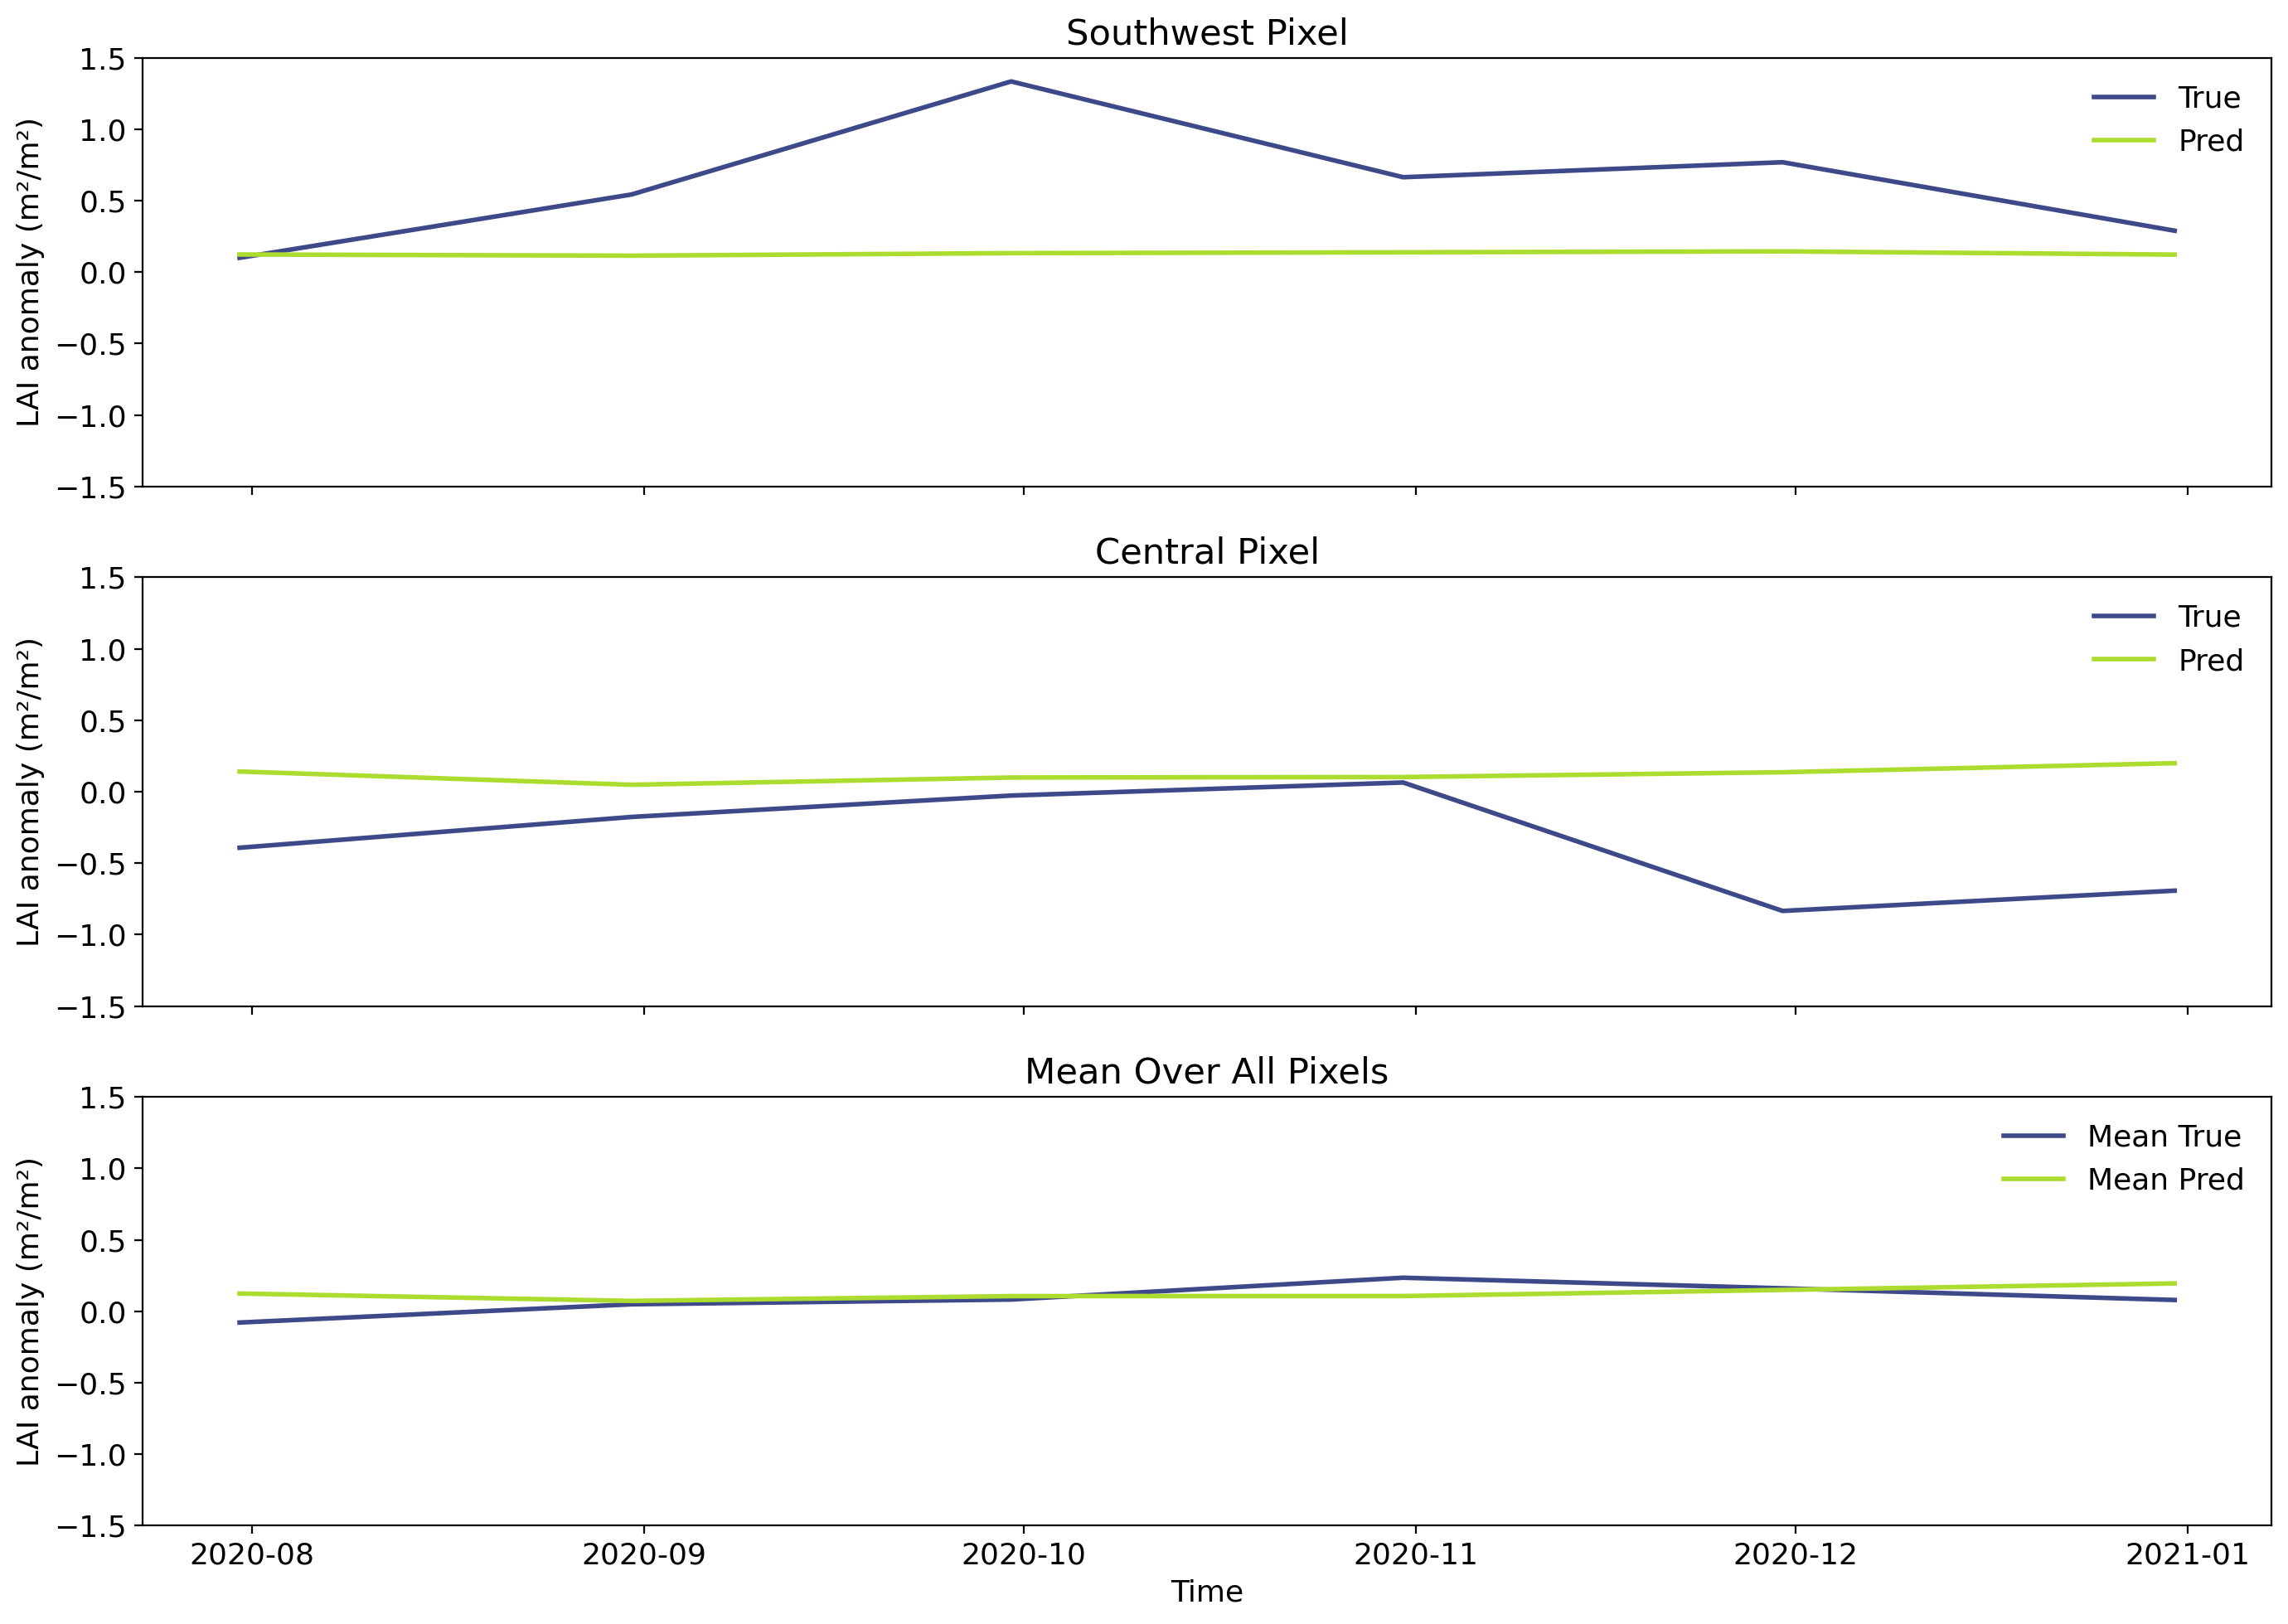

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define your two points ---
sw_lat, sw_lon = -12.504240199016463, -71.818702040585     # southwest corner  
ct_lat, ct_lon = -11.730855612666398, -70.79697352496      # central

# --- Find nearest pixel in df ---
def nearest_pixel(df, target_lat, target_lon):
    d = np.sqrt((df.lat - target_lat)**2 + (df.lon - target_lon)**2)
    idx = d.idxmin()
    return df.loc[idx, ['lat','lon']]

sw_actual = nearest_pixel(df, sw_lat, sw_lon)
ct_actual = nearest_pixel(df, ct_lat, ct_lon)

pix_sw = df[(df.lat == sw_actual.lat) & (df.lon == sw_actual.lon)]
pix_ct = df[(df.lat == ct_actual.lat) & (df.lon == ct_actual.lon)]

# --- Compute mean time series ---
mean_ts = df.groupby("time")[["pred","true"]].mean()

# --- Determine common y-axis limits ---
ymin = min(pix_sw.true.min(), pix_sw.pred.min(),
           pix_ct.true.min(), pix_ct.pred.min(),
           mean_ts.true.min(), mean_ts.pred.min())
ymax = max(pix_sw.true.max(), pix_sw.pred.max(),
           pix_ct.true.max(), pix_ct.pred.max(),
           mean_ts.true.max(), mean_ts.pred.max())
ymin = -1.5
ymax = 1.5

# --- Plot all three subplots with same size and axes ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, sharey=True)

# Colors
true_color = "#3e4989"
pred_color = "#addc30"

# Southwest pixel
axes[0].plot(pix_sw.time, pix_sw.true, label="True", color=true_color, linewidth=2)
axes[0].plot(pix_sw.time, pix_sw.pred, label="Pred", color=pred_color, linewidth=2)
axes[0].set_title("Southwest Pixel")
axes[0].legend()
axes[0].set_ylabel("LAI anomaly (m²/m²)")

# Central pixel
axes[1].plot(pix_ct.time, pix_ct.true, label="True", color=true_color, linewidth=2)
axes[1].plot(pix_ct.time, pix_ct.pred, label="Pred", color=pred_color, linewidth=2)
axes[1].set_title("Central Pixel")
axes[1].legend()
axes[1].set_ylabel("LAI anomaly (m²/m²)")

# Mean over all pixels
axes[2].plot(mean_ts.index, mean_ts["true"], label="Mean True", color=true_color, linewidth=2)
axes[2].plot(mean_ts.index, mean_ts["pred"], label="Mean Pred", color=pred_color, linewidth=2)
axes[2].set_title("Mean Over All Pixels")
axes[2].legend()
axes[2].set_ylabel("LAI anomaly (m²/m²)")
axes[2].set_xlabel("Time")

# Set common y-limits
for ax in axes:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]

# # Number of features to consider at every split
# max_features = ['sqrt', 'log2', None]

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [5, 10, 15, 25]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [4, 8, 12,16]

# # Method of selecting samples for training each tree
# bootstrap = [True]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [ ]:
# reg0 = RandomForestRegressor(random_state=0)
# # perform cross validation
# rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
#                                 n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
# rf_tas = rf_random0.fit(train_lags_clean,y_train_lags_clean)

# print("The best hyperparameters: \n",rf_tas.best_params_)

In [9]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 300]),
        "max_depth": trial.suggest_categorical("max_depth", [10, 20, 30, 40, 50, None]),
        "min_samples_split": trial.suggest_categorical("min_samples_split", [5,10,15,25]),
        "min_samples_leaf": trial.suggest_categorical("min_samples_leaf",  [4,8,12,16]),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),
    }

    model = RandomForestRegressor(
        **params,
        random_state=0,
        n_jobs=-1
    )

    cv_scores = cross_val_score(
        model, X_train, y_train['lai'],
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    return cv_scores.mean()  # Optuna maximizes objective

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=30, n_jobs=1)   # 50 trials usually beats 500 random grid runs

print("Best params:", study.best_params)
print("Best score:", study.best_value)

[I 2025-12-17 15:05:27,860] A new study created in memory with name: no-name-96234739-695a-44f0-a621-e023808da57e
[I 2025-12-17 15:08:24,902] Trial 0 finished with value: -0.09134181892848132 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 25, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: -0.09134181892848132.
[I 2025-12-17 15:10:58,155] Trial 1 finished with value: -0.09068623804910218 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: -0.09068623804910218.
[I 2025-12-17 15:13:17,897] Trial 2 finished with value: -0.09160368332435259 and parameters: {'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: -0.09068623804910218.
[I 2025-12-17 15:14:37,203] Trial 3 finished with value: -0

Best params: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}
Best score: -0.09000463946706662
